# Reconstruct Dictionary via Coder Sampling

Due to the slight left-leaning nature of our crowd-sourced annotator sample, this notebook examines whether the e-MFD is biased towards any particular political affiliation. To examine whether this is the case, the same annotation preprocessing pipeline is executed on all produced annotations. Next, the slightly underrepresented republican male and female annotators are  upsampled to match the frequency of democratic male and female annotators. Thereafter, we ran the same dictionary construction algorithm on the resampled annotations and compare differences in foundation probabilities and sentiment scores across dictionaries.

***

In [1]:
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# NLP
import spacy, re, fnmatch 
nlp = spacy.load('en')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Stopwords 
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS

#Uitls
from multiprocessing import Pool

***

### Obtain Coder Information

In [2]:
coders = pd.read_csv('data/pa_coder_complete.csv').set_index('coder_id')
coders = coders[coders['Political Affiliation (US)']!='MISSING']

**Ratios in population (Attempted Sampling Frame in Crowdcoding Study):**

- https://www.census.gov/quickfacts/table/PST045216/00
- Female Democrats: 0.24375 
- Female Republicans: 0.23375
- Male Democrats: 0.23625 
- Male Republicans: 0.22625  
- Other: 3% Male, 3% Female 

**Actual Ratios in data:**

In [3]:
coders.groupby('sex')['Political Affiliation (US)'].value_counts() / len(coders)

sex     Political Affiliation (US)
Female  Democrat                      0.368627
        Republican                    0.076471
        Other                         0.025490
        None                          0.021569
Male    Democrat                      0.317647
        Republican                    0.135294
        Other                         0.029412
        None                          0.015686
Name: Political Affiliation (US), dtype: float64

**Frequencies in Data**

In [4]:
coders.groupby('sex')['Political Affiliation (US)'].value_counts() 

sex     Political Affiliation (US)
Female  Democrat                      188
        Republican                     39
        Other                          13
        None                           11
Male    Democrat                      162
        Republican                     69
        Other                          15
        None                            8
Name: Political Affiliation (US), dtype: int64

***

**NOTE:** Before re-sampling and preprocessing the highlights for dictionary creation, we were curious to see: 
- (a) How many highlights were produced by each coder
- (b) Whether democrats and republican coders produced different frequencies of highlights overall and with respect to each foundation

In [5]:
# Load all highlights and join with coder information
hl = pd.read_csv('data/highlights_raw.csv', index_col=0)
hl = hl[hl.focus_duration >= 45*60]
hl = hl[hl['coder_id']!= 549] # Removed this participant as they produced over 1000 highlights
hl = hl.set_index('coder_id').join(coders)
hl['hl_id'] = hl.reset_index().index
hl = hl.reset_index()
hl['coder_id'] = hl['coder_id'].astype(int)

**Total Highlight Frequency Per Coder**

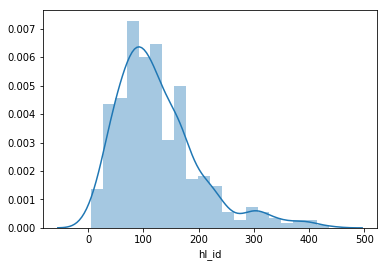

In [6]:
sns.distplot(hl.groupby('coder_id').nunique()['hl_id'])

**Highlight Frequencies By Political Orientation Across Foundations**

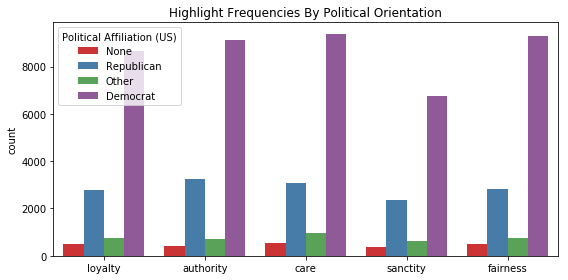

In [7]:
fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=1, sharey=True, sharex=True)
sns.countplot(x='assigned_domain', data=hl[['assigned_domain', 'Political Affiliation (US)']], hue='Political Affiliation (US)', ax=ax, palette='Set1')

ax.set_title('Highlight Frequencies By Political Orientation')
ax.set_xlabel('')
plt.tight_layout()

As can be seen from the above chart, there are more highlights produced by democrats as there are by republicans.

**Total Highlight Frequency By Political Affiliation**

In [8]:
hl.groupby('Political Affiliation (US)').nunique()['hl_id']

Political Affiliation (US)
Democrat      43211
None           2328
Other          3801
Republican    14278
Name: hl_id, dtype: int64

***

## Preprocess Highlights

**Note:** All of the following steps match the procedure applied to construct the non re-sampled E-MFD (see dictionary_construction.ipynb)

In [9]:
def filter_hl(hl):
    
    '''Ensures that each document has been coded by at least two coders that differed in their assigned foundation'''
    
    grouped_doc = hl.groupby(hl.document_id).nunique()
    grouped_doc = grouped_doc[grouped_doc.assigned_domain >= 2]
    grouped_doc = grouped_doc[np.logical_and(grouped_doc.coder_id <= 15, grouped_doc.coder_id >= 2)] 
    
    keep_docs = grouped_doc.index.values
    hl = hl[hl.document_id.isin(keep_docs)]
    
    return hl

In [10]:
def remove_entities(hl):
    
    '''Removes any entity contained in highlights'''
    
    entities = []
    for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['tagger', 'parser','textcat'],
                        batch_size=500, n_threads=-1):
        entities.append(list(zip([ent.text for ent in doc.ents],[ent.label_ for ent in doc.ents])))
        
    entities = [ent for highlight in entities for ent in highlight]
    rem_entities = []
    for ent in entities:
        if ent[1] != 'PRODUCT' and len(ent[0]) >= 3:
            rem_entities.append(ent)  

    rem_entities = [x[0] for x in set(rem_entities)]
    rem_entities = [x.replace('(','') for x in rem_entities]
    rem_entities = [x.replace(')','') for x in rem_entities]
    
    hl['content'] = hl['content'].str.replace(')','')
    hl['content'] = hl['content'].str.replace('(','')

    for ent in rem_entities:
        pat = r"\b"+ ent + r"\b"
        hl['content'] = hl['content'].str.replace(pat,'') 
        
    return hl

In [11]:
def remove_punctuation(hl):
    
    '''Removes punctuations and extra whitespace contained in highlights'''
    
    from string import punctuation
    punctuation += '’'
    punctuation = punctuation.replace('\'','')
    punctuation = punctuation.replace('-','')
    for punct in punctuation:
        hl['content'] = hl['content'].str.replace(punct,'')

    hl['content'] = hl['content'].str.replace(r"\s+"," ")    
    
    return hl

In [12]:
def pos_tag_sentiment(hl):
    
    '''Performs part of speech tagging.
    Only certain POS are kept in the data (see keep_pos). 
    For a full tagging scheme, see https://spacy.io/api/annotation#pos-tagging 
    '''
    
    tokens = []
    pos = []
    tups = []

    for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['ner','textcat', 'parser'],
                        batch_size=500, n_threads=-1):    
        tokens.append([n.text for n in doc])
        pos.append([n.tag_ for n in doc])
        tups.append(list(zip([n.text for n in doc], [n.tag_ for n in doc])))
        
    hl['tups'] = tups

    # Define POS to keep and special characters to delete
    keep_pos = ['NN','NNS','JJ','VB','VBD','VBG','VBN','VBP','VBZ','RB']
    no_chars = ["…","'ve","'s","'ll","'d","\"","'m","'s","'re","–-",'–-', '‘', '’d', '’ll', '’m', '’re', '’s', '’ve',
                '“', ',,',',','(',')','.', '”', '\n\n',"@realDonaldTrump","n't",'\xad']

    hl['tokens'] = hl.tups.apply(lambda y: [x[0] for x in y if np.logical_and(x[0] not in no_chars, x[1] in keep_pos)])

    # Remove stopwords
    stopwords = set(list(nltk_stopwords) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))
    hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (x not in stopwords)]) 

    # Only keep words with min. three characters
    hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (len(x) >= 3)]) 

    # Lowercase
    hl['tokens'] = hl.tokens.apply(lambda y: [x.lower() for x in y])

    hl['content'] = hl.tokens.apply(lambda x: ','.join(x))
    hl['content'] = hl.content.str.replace(',',' ')
    
    del hl['tups']
    
    #Sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    hl['vader'] = hl['content'].apply(lambda x: analyzer.polarity_scores(x)) 
    hl['comp'] = hl['vader'].apply(pd.Series)['compound']
    hl['pos'] = hl['vader'].apply(pd.Series)['pos']
    hl['neg'] = hl['vader'].apply(pd.Series)['neg']
    hl['neu'] = hl['vader'].apply(pd.Series)['neu']
    hl['sent_foundation'] = ''
    
    for i,row in hl.iterrows():
        if row.comp < 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.vice'
        elif row.comp > 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.virtue'
        elif row.comp == 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.context'
            
    del hl['vader']
    
    return hl

def parallelize_dataframe(df, func):
    
    '''Simple function to multiprocess functions on dataframe.
    Adjust the Pool value to match your machine CPU capability'''
    
    df_split = np.array_split(df, 12)
    pool = Pool(12)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    
    return df

In [13]:
# Perform preprocessing by calling all functions 
print("Starting highlight preprocessing. This will take a few minutes.")
print('Total number of highlights in data before preprocessing:', len(hl))
filtered_hl = parallelize_dataframe(hl, filter_hl)
print("Number of highlights after filtering bad highlights and documents:", len(filtered_hl))
removed_entities = parallelize_dataframe(filtered_hl, remove_entities)
print("Removed entities from highlights.")
removed_punctuation = parallelize_dataframe(removed_entities, remove_punctuation)
print("Removed punctuations from highlights.")
hl = parallelize_dataframe(removed_punctuation, pos_tag_sentiment)
print("POS tagging completed.")

# Filter highlights that are longer than the 90th percentile of highlight length to minimize noise
hl['length'] = hl.tokens.apply(lambda x: len(x))
hl = hl[np.logical_and(hl.length >= 3, hl.length <= hl.length.quantile(0.90))] 
print('Highlight preprocessing completed.')
print("Total number of highlights in training data:", len(hl))
print('Total number of unique documents in data:', len(hl.document_id.unique()))
print('Total number of unique coders:', len(hl.coder_id.unique()))

Starting highlight preprocessing. This will take a few minutes.
Total number of highlights in data before preprocessing: 63958
Number of highlights after filtering bad highlights and documents: 42109
Removed entities from highlights.
Removed punctuations from highlights.
POS tagging completed.
Highlight preprocessing completed.
Total number of highlights in training data: 31894
Total number of unique documents in data: 977
Total number of unique coders: 468


***

**Coder Rations after Preprocessing**

In [14]:
hl.drop_duplicates('coder_id').groupby('sex')['Political Affiliation (US)'].value_counts() / len(hl.drop_duplicates('coder_id'))

sex     Political Affiliation (US)
Female  Democrat                      0.376068
        Republican                    0.070513
        None                          0.023504
        Other                         0.023504
Male    Democrat                      0.311966
        Republican                    0.141026
        Other                         0.027778
        None                          0.012821
Name: Political Affiliation (US), dtype: float64

In [15]:
hl.drop_duplicates('coder_id').groupby('sex')['Political Affiliation (US)'].value_counts() 

sex     Political Affiliation (US)
Female  Democrat                      176
        Republican                     33
        None                           11
        Other                          11
Male    Democrat                      146
        Republican                     66
        Other                          13
        None                            6
Name: Political Affiliation (US), dtype: int64

In [16]:
hl_f_reps = hl[np.logical_and(hl['Political Affiliation (US)']=='Republican', hl['sex']=='Female')]
hl_m_reps = hl[np.logical_and(hl['Political Affiliation (US)']=='Republican', hl['sex']=='Male')]

hl_m_dem = hl[np.logical_and(hl['Political Affiliation (US)']=='Democrat', hl['sex']=='Female')]
hl_f_dem = hl[np.logical_and(hl['Political Affiliation (US)']=='Democrat', hl['sex']=='Male')]

hl_dems = hl[hl['Political Affiliation (US)']=='Democrat']
hl_other = hl[np.logical_or(hl['Political Affiliation (US)']=='Other', hl['Political Affiliation (US)']=='None')]

In [17]:
print('Total number of female republicans:', len(hl_f_reps['coder_id'].unique()))

Total number of female republicans: 33


In [18]:
print('Total number of male republicans:', len(hl_m_reps['coder_id'].unique()))

Total number of male republicans: 66


In [19]:
print('Total number of female democarats:', len(hl_f_dem['coder_id'].unique()))

Total number of female democarats: 146


In [20]:
print('Total number of male democarats:', len(hl_m_dem['coder_id'].unique()))

Total number of male democarats: 176


***

Upsample Republicans to match Democrats

In [21]:
def copy_coders(df, ix):
    copied = df.copy()
    copied['coder_id'] = copied['coder_id'].apply(lambda x: str(x)+'_'+str(ix))
    return copied

In [22]:
hl_f_reps_1 = copy_coders(hl_f_reps, 1)
hl_f_reps_2 = copy_coders(hl_f_reps, 2)
hl_f_reps_3 = copy_coders(hl_f_reps, 3)
hl_f_reps_4 = copy_coders(hl_f_reps, 4)
hl_f_reps_5 = copy_coders(hl_f_reps, 5)
hl_f_upsampled = pd.concat([hl_f_reps_1,hl_f_reps_2, hl_f_reps_3,hl_f_reps_4])

In [23]:
print('Total number of female republicans after upsampling:', len(hl_f_upsampled['coder_id'].unique()))

Total number of female republicans after upsampling: 132


In [24]:
hl_m_reps_1 = copy_coders(hl_m_reps, 1)
hl_m_reps_2 = copy_coders(hl_m_reps, 2)

m_reps_ids = np.random.choice(hl_m_reps['coder_id'].unique(), 10, replace=False)
m_reps_sample = hl_m_reps[hl_m_reps['coder_id'].isin(m_reps_ids)]

hl_m_reps_3 = copy_coders(m_reps_sample, 3)
hl_m_upsampled = pd.concat([hl_m_reps_1,hl_m_reps_2, hl_m_reps_3])

In [25]:
print('Total number of male republicans after upsampling:', len(hl_m_upsampled['coder_id'].unique()))

Total number of male republicans after upsampling: 142


Bring them all together

In [26]:
hl_sampled = pd.concat([hl_dems, hl_other, hl_f_upsampled, hl_m_upsampled])

**Ratios after Re-Sampling**

In [27]:
hl_sampled.groupby('sex')['Political Affiliation (US)'].value_counts() / len(hl_sampled)

sex     Political Affiliation (US)
Female  Democrat                      0.266992
        Republican                    0.239675
        None                          0.019713
        Other                         0.017304
Male    Democrat                      0.214031
        Republican                    0.212381
        Other                         0.021898
        None                          0.008006
Name: Political Affiliation (US), dtype: float64

In [28]:
len(hl_sampled)

44844

***

**Highlight Ratios after Highlight Preprocessing**

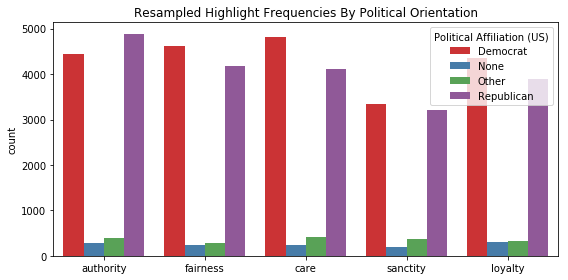

In [29]:
fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=1, sharey=True, sharex=True)
sns.countplot(x='assigned_domain', data=hl_sampled[['assigned_domain', 'Political Affiliation (US)']], hue='Political Affiliation (US)', ax=ax, palette='Set1')

ax.set_title('Resampled Highlight Frequencies By Political Orientation')
ax.set_xlabel('')
plt.tight_layout()

***

## Construct Vocabulary

In the following steps, we construct the `vocabulary`. This vocabulary is a DataFrame that is indexed by each unique word that is found in the processed `hl`.

In [30]:
hl = hl_sampled.copy()

In [31]:
tokens = [token for highlight in hl.tokens.values for token in highlight]
print('Total number of words in highlights:', len(tokens))

Total number of words in highlights: 272618


In [32]:
vocab = set(tokens)
vocab = [x.lower() for x in vocab]
vocab = [x for x in vocab if len(x) >= 3]

stopwords = set(list(nltk_stopwords) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))
vocab = [x for x in vocab if x not in stopwords]

vocab = pd.DataFrame(vocab)
vocab = vocab.rename(columns={0:'word'})

# Remove words with numbers 
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def hasPunct(inputString):
    from string import punctuation 
    if any(char in punctuation for char in inputString):
        return 'True'
    else:
        return 'False'

vocab['has_number'] = vocab.word.apply(lambda x: hasNumbers(x))
vocab['has_punct'] = vocab.word.apply(lambda x: hasPunct(x))

vocab = vocab[np.logical_and(vocab['has_number']==False, vocab['has_punct']=='False')]

del vocab['has_number']
del vocab['has_punct']

base_founds = ['care','fairness','loyalty','authority','sanctity']
    
for f in base_founds:
    vocab[str(f)+'_hlcts'] = 0.0

vocab.index = vocab.word

print('Final vocabulary size after preprocessing:', len(vocab))

Final vocabulary size after preprocessing: 15413


In [33]:
vocab.head()

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts
word,,,,,,
showcasing,showcasing,0.0,0.0,0.0,0.0,0.0
miscarried,miscarried,0.0,0.0,0.0,0.0,0.0
educated,educated,0.0,0.0,0.0,0.0,0.0
granting,granting,0.0,0.0,0.0,0.0,0.0
lost,lost,0.0,0.0,0.0,0.0,0.0


### How many times has a word in the vocabulary been seen by (a) ALL coders and (b) by coders with a certain foundation?

#### 1) How often does each word appear in each document

In the cell below, we read in all the news articles that were seen and coded by the human coders. We then preprocess the document text by removing punctuations and stopwords. In a final step, we compute the frequency with which each word appeared in each document.

In [34]:
# Get the documents
hl_docs = pd.read_pickle('data/coded_news.pkl')
corpus = hl_docs[hl_docs.index.isin(hl.document_id)]
corpus['text'] = corpus['text'].str.lower()
from string import punctuation

def preprocess(text):
    raw_text = text
    for s in punctuation:
        raw_text = raw_text.replace(s,'')
    for s in stopwords:
        regex = re.compile(r"\b{}\b".format(s))
        raw_text = re.sub(regex, '', raw_text)
    raw_text = raw_text.replace('\'','')
    raw_text = raw_text.strip()
    raw_text = " ".join(raw_text.split())
    return raw_text

corpus['text'] = corpus['text'].apply(lambda x:preprocess(x))

# Calculate term frequency
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus['text'])
word_per_doc = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
word_per_doc.index = corpus.index
word_per_doc = word_per_doc.T
word_per_doc = word_per_doc.reset_index().rename(columns={'index':'word'})
word_per_doc = word_per_doc[word_per_doc.word.isin(vocab.word)]
word_per_doc = word_per_doc.set_index('word').T
word_per_doc = word_per_doc.fillna(0)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The result is a D x W matrix where D = number of unique documents and W = number of unique words. Each cell in that matrix captures how often that word appeared in that document.

In [35]:
word_per_doc.head()

word,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,...,zenith,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo
4877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4881,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2) How many coders saw each document?

In the following, we determine the total number of coders that have seen each document (see the `total_seen` column on the right.)

In [36]:
coders_per_doc = hl.groupby('document_id').nunique()['coder_id']
coders_per_doc = coders_per_doc.fillna(0)

In [37]:
# Join these and multiply these with the above raw counts to get the total_seen variable 
total_seen = word_per_doc.join(coders_per_doc.rename('total_seen'))
total_seen[[c for c in total_seen.columns if c != 'total_seen']] = total_seen[[c for c in total_seen.columns if c != 'total_seen']].multiply(total_seen['total_seen'], axis=0)

In [38]:
total_seen.head()

,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,...,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,total_seen
4877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
4879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4881,0,0,10,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [39]:
# Now, get the column sum to obtain total number of times this word was seen by coders across documents and add that variable to the vocabulary
vocab = vocab.join(total_seen[[c for c in total_seen.columns if c != 'total_seen']].sum().rename('total_seen'))

#### 3) How often was each word seen by coders with a given foundation?

Next up, we determine how often each word has been seen by a coder with a certain assigned foundation.

In [40]:
# Every unique coder is assigned a foundation per document 
# Question: for each document, get mapping of coder_id and assigned foundation 

# Make dataframe that is indexed by each document id
# Loop over each document and get the coders and their assigned foundation 
seen_by_foundation = pd.DataFrame(index=corpus.index, columns=['seen_care', 'seen_fairness','seen_loyalty','seen_authority','seen_sanctity'])

In [41]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,NaN,NaN,NaN,NaN,NaN
4879,NaN,NaN,NaN,NaN,NaN
4881,NaN,NaN,NaN,NaN,NaN
4887,NaN,NaN,NaN,NaN,NaN
4890,NaN,NaN,NaN,NaN,NaN


In [42]:
# In a first step, loop over the unique documents
doc_ids = seen_by_foundation.index.unique()
for doc_id in doc_ids:
    # Select all the hls that correspond to that doc_id
    document = hl[hl['document_id'] == doc_id]
    # Obtain the unique coder_ids per document and their assigned foundations
    coders_foundation = document.groupby('assigned_domain').nunique()['coder_id']
    # Join these counts with the seen_by_foundation dataframe
    try:
        seen_by_foundation.at[doc_id, 'seen_care'] = coders_foundation.care
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_fairness'] = coders_foundation.fairness
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_loyalty'] = coders_foundation.loyalty
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_authority'] = coders_foundation.authority
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_sanctity'] = coders_foundation.sanctity
    except:
        pass

In [43]:
seen_by_foundation = seen_by_foundation.fillna(0)

In [44]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,0,2,1,5,4
4879,2,0,2,7,0
4881,2,2,2,0,4
4887,2,2,3,1,1
4890,4,0,0,0,3


In [45]:
# Join the coders per foundation with the word counts per document
seen_by_foundation = seen_by_foundation.join(word_per_doc)

In [46]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity,aback,abandon,abandoned,abandoning,abandonment,...,zenith,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo
4877,0,2,1,5,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4879,2,0,2,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4881,2,2,2,0,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4887,2,2,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4890,4,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
seen_cols = [c for c in seen_by_foundation.columns if c.startswith('seen_')]

In [48]:
# Multiply each word count by the total sum of foundation-coders that saw this word
for seen_f in seen_cols:
    word_seen_vec = pd.DataFrame(seen_by_foundation[[seen_f]+[c for c in seen_by_foundation.columns if not c.startswith('seen_')]][[c for c in seen_by_foundation.columns if not c.startswith('seen_')]].apply(lambda x: x * seen_by_foundation[seen_f]).sum().rename(seen_f))
    vocab = vocab.join(word_seen_vec)

In [49]:
vocab.head()

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts,total_seen,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
word,,,,,,,,,,,,
showcasing,showcasing,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,1.0,1.0,0.0
miscarried,miscarried,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,1.0,2.0
educated,educated,0.0,0.0,0.0,0.0,0.0,122.0,24.0,19.0,28.0,29.0,22.0
granting,granting,0.0,0.0,0.0,0.0,0.0,88.0,6.0,17.0,21.0,34.0,10.0
lost,lost,0.0,0.0,0.0,0.0,0.0,1577.0,318.0,317.0,298.0,370.0,275.0


As can be seen from the above vocabulary, we now know that the word obscenity was seen a total of 9 times across all coders. Respectively, convoy has been seen by 1 care-coder, 1 fairness-coder, and so on.

In [50]:
vocab = vocab.dropna(subset=['total_seen'])
vocab = vocab[vocab.total_seen > 0]

### 4) Score Vocabulary

As a first step in scoring the vocabulary, we iterate over all highlights. Once a word is found in the vocabulary, we first obtain the foundation of the highlight where this word was mentioned. Then, in the vocabulary, we go to the column that reflects this foundation and increment a `1`. By doing so, we create a vocabulary that reflects how often a certain word appeared in highlights with a certain foundation.

In [51]:
# Add columns to store sentiments of highlights
for f in base_founds:
    vocab[f+'_pos'] = 0.0
    vocab[f+'_neg'] = 0.0
    vocab[f+'_neu'] = 0.0
    vocab[f+'_sent'] = 0.0 
    
vocab['avg_pos'] = 0.0
vocab['avg_neg'] = 0.0
vocab['avg_neu'] = 0.0

In [52]:
# Iterate over each word in each highlight and increment foundation counts
# Transform vocab into dictionary for faster hash functionality
words = {k:0.0 for k in vocab.index} 

for i,row in hl.iterrows():

    highlight = row.tokens
    base_found = row.assigned_domain

    pos = row.pos
    neg = row.neg
    neu = row.neu
    comp = row.comp
    
    for word in highlight:
        if word in words.keys():
            vocab.at[str(word),base_found+'_hlcts'] += 1
            vocab.at[str(word),base_found+'_pos'] += pos
            vocab.at[str(word),base_found+'_neg'] += neg
            vocab.at[str(word),base_found+'_neu'] += neu
            vocab.at[str(word),base_found+'_sent'] += comp

vocab['sum_hl'] = vocab[[c for c in vocab.columns if c.endswith('hlcts')]].sum(axis=1)
vocab = vocab.fillna(0)

In [53]:
vocab = vocab[vocab.sum_hl > 0]

### 5) Divide highlight counts by seen_by Columns

In the next step, we divide the total frequency a word has been highlighted with a certain foundation by the number of times this word has been seen by coders who were assigned that foundation. Doing so yields us a probabality that a word was highlighted by a coder. As an example, if the word `kill` has .8 in the Care_norm column, then this means that there is a 80% probability that `kill` was highlighted by a coder assigned the Care foundation.

In [54]:
# Create Probability columns 
for f in base_founds:
    vocab[f+'_p'] = 0.0
    
for i,row in vocab.iterrows():
    if row.seen_care != 0:
        vocab.at[i, 'care_p'] = row['care_hlcts'] / row.seen_care
        
    if row.seen_fairness != 0:
        vocab.at[i, 'fairness_p'] = row['fairness_hlcts'] / row.seen_fairness
   
    if row.seen_authority != 0:
        vocab.at[i, 'authority_p'] = row['authority_hlcts'] / row.seen_authority

    if row.seen_loyalty != 0:
        vocab.at[i, 'loyalty_p'] = row['loyalty_hlcts'] / row.seen_loyalty
        
    if row.seen_sanctity != 0:
        vocab.at[i, 'sanctity_p'] = row['sanctity_hlcts'] / row.seen_sanctity

In [55]:
# Remove words whose probabilities are above 1 for any given foundation (caused by minor preprocessing glitches)
probabilities = [c for c in vocab.columns if c.endswith('_p')]
vocab = vocab.iloc[pd.np.where(vocab[probabilities].le(1).all(1, skipna=True))]

In [56]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 15223


In [57]:
# Ensure each word has been seen at least 10 times by any foundation coder
vocab = vocab[(vocab['seen_care'] > 10) & (vocab['seen_fairness'] > 10) & (vocab['seen_loyalty'] > 10) & (vocab['seen_authority'] > 10) & (vocab['seen_sanctity'] > 10)] 

In [58]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 4917


In [59]:
# Ensure each word has been highlighted at least 5 times with any foundation
vocab = vocab.iloc[pd.np.where(vocab[[c for c in vocab.columns if c.endswith('_hlcts')]].ge(5).any(1, skipna=True))]

In [60]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 3868


In [61]:
# Divide sentiment columns by hlcts to obtain average sentiment scores
for i,row in vocab.iterrows():
    if row.care_hlcts != 0:
        vocab.at[i, 'care_pos'] = row['care_pos'] / row.care_hlcts
        vocab.at[i, 'care_neg'] = row['care_neg'] / row.care_hlcts
        vocab.at[i, 'care_neu'] = row['care_neu'] / row.care_hlcts
        vocab.at[i, 'care_sent'] = row['care_sent'] / row.care_hlcts
        
    if row.fairness_hlcts != 0:
        vocab.at[i, 'fairness_pos'] = row['fairness_pos'] / row.fairness_hlcts
        vocab.at[i, 'fairness_neg'] = row['fairness_neg'] / row.fairness_hlcts
        vocab.at[i, 'fairness_neu'] = row['fairness_neu'] / row.fairness_hlcts
        vocab.at[i, 'fairness_sent'] = row['fairness_sent'] / row.fairness_hlcts
        
    if row.loyalty_hlcts != 0:
        vocab.at[i, 'loyalty_pos'] = row['loyalty_pos'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_neg'] = row['loyalty_neg'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_neu'] = row['loyalty_neu'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_sent'] = row['loyalty_sent'] / row.loyalty_hlcts
        
    if row.authority_hlcts != 0:
        vocab.at[i, 'authority_pos'] = row['authority_pos'] / row.authority_hlcts
        vocab.at[i, 'authority_neg'] = row['authority_neg'] / row.authority_hlcts
        vocab.at[i, 'authority_neu'] = row['authority_neu'] / row.authority_hlcts
        vocab.at[i, 'authority_sent'] = row['authority_sent'] / row.authority_hlcts
        
    if row.sanctity_hlcts != 0:
        vocab.at[i, 'sanctity_pos'] = row['sanctity_pos'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_neg'] = row['sanctity_neg'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_neu'] = row['sanctity_neu'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_sent'] = row['sanctity_sent'] / row.sanctity_hlcts

In [62]:
vocab = vocab.fillna(0)

In [63]:
# Define aggregated columns
weights_f = [c for c in vocab.columns if c.endswith('_norm')]

In [64]:
sent_cols = [c for c in vocab.columns if c.endswith('_sent')]
probabilities = [c for c in vocab.columns if c.endswith('_p')]

In [65]:
vocab[probabilities+sent_cols].to_pickle('dictionaries/resampled_emfd_scoring.pkl')

***

## Compare with non-resampled E-MFD

In [66]:
emfd = pd.read_pickle('dictionaries/emfd_scoring.pkl')

In [67]:
sampled = pd.read_pickle('dictionaries/resampled_emfd_scoring.pkl')
for f in sampled.columns:
    sampled = sampled.rename(columns={f:'res_'+f})

Below, we join together the foundation probabilities of the original E-MFD and the resampled E-MFD.

In [68]:
joined = emfd.join(sampled).dropna(how='any')

Next, we subtract the E-MFD weights from the resampled E-MFD and obtain the absolute value of their difference.

In [69]:
joined['care-care'] = (joined['care_p'] - joined['res_care_p']).abs()
joined['fairness-fairness'] = (joined['fairness_p'] - joined['res_fairness_p']).abs()
joined['loyalty-loyalty'] = (joined['loyalty_p'] - joined['res_loyalty_p']).abs()
joined['authority-authority'] = (joined['authority_p'] - joined['res_authority_p']).abs()
joined['sanctity-sanctity'] = (joined['sanctity_p'] - joined['res_sanctity_p']).abs()

joined['care_sent-care_sent'] = (joined['care_sent'] - joined['res_care_sent']).abs()
joined['fairness_sent-fairness_sent'] = (joined['fairness_sent'] - joined['res_fairness_sent']).abs()
joined['loyalty_sent-loyalty_sent'] = (joined['loyalty_sent'] - joined['res_loyalty_sent']).abs()
joined['authority_sent-authority_sent'] = (joined['authority_sent'] - joined['res_authority_sent']).abs()
joined['sanctity_sent-sanctity_sent'] = (joined['sanctity_sent'] - joined['res_sanctity_sent']).abs()

In [70]:
diff_cols = ['care-care', 'fairness-fairness', 'loyalty-loyalty', 
             'authority-authority', 'sanctity-sanctity', 
            'care_sent-care_sent','fairness_sent-fairness_sent',
            'loyalty_sent-loyalty_sent', 'authority_sent-authority_sent',
            'sanctity_sent-sanctity_sent']

As can be seen from the below table, the median absolute difference in weights is around 0.06, measured on a scale from 0 to 1.

In [71]:
joined[diff_cols].describe().round(2)

,care-care,fairness-fairness,loyalty-loyalty,authority-authority,sanctity-sanctity,care_sent-care_sent,fairness_sent-fairness_sent,loyalty_sent-loyalty_sent,authority_sent-authority_sent,sanctity_sent-sanctity_sent
count,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00
mean,0.02,0.02,0.02,0.02,0.02,0.06,0.06,0.06,0.06,0.06
std,0.03,0.03,0.02,0.03,0.03,0.09,0.09,0.08,0.08,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00
50%,0.02,0.02,0.02,0.02,0.01,0.03,0.04,0.03,0.03,0.03
75%,0.03,0.03,0.03,0.03,0.03,0.08,0.09,0.08,0.08,0.08
max,0.26,0.27,0.23,0.31,0.25,0.96,0.82,0.84,0.88,0.88


**Distribution of Absolute Differences Between Weights**

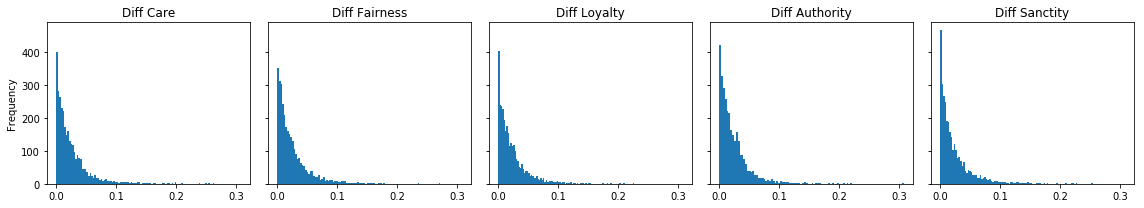

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,3), sharey=True, sharex=True)
joined['care-care'].plot(kind='hist',bins=100, ax=ax[0], title='Diff Care')
joined['fairness-fairness'].plot(kind='hist',bins=100, ax=ax[1], title='Diff Fairness')
joined['loyalty-loyalty'].plot(kind='hist',bins=100, ax=ax[2], title='Diff Loyalty')
joined['authority-authority'].plot(kind='hist',bins=100, ax=ax[3], title='Diff Authority')
joined['sanctity-sanctity'].plot(kind='hist',bins=100, ax=ax[4], title='Diff Sanctity')
plt.tight_layout()

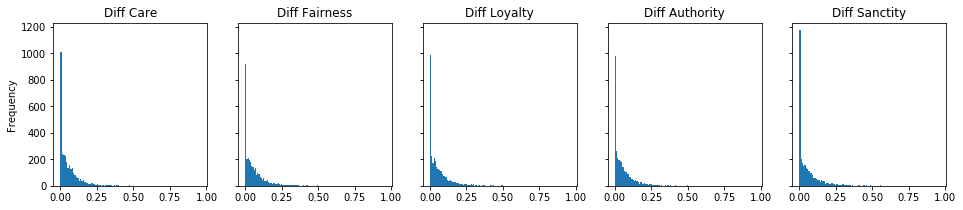

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,3), sharey=True, sharex=True)
joined['care_sent-care_sent'].plot(kind='hist',bins=100, ax=ax[0], title='Diff Care')
joined['fairness_sent-fairness_sent'].plot(kind='hist',bins=100, ax=ax[1], title='Diff Fairness')
joined['loyalty_sent-loyalty_sent'].plot(kind='hist',bins=100, ax=ax[2], title='Diff Loyalty')
joined['authority_sent-authority_sent'].plot(kind='hist',bins=100, ax=ax[3], title='Diff Authority')
joined['sanctity_sent-sanctity_sent'].plot(kind='hist',bins=100, ax=ax[4], title='Diff Sanctity')

Finally, the below heatmap illustrates the correlation between weights taken from the non-resampled E-MFD and the resampled E-MFD.

Text(0.5, 1.0, 'Correlation between E-MFD Weights and Resampled MFD Weights')

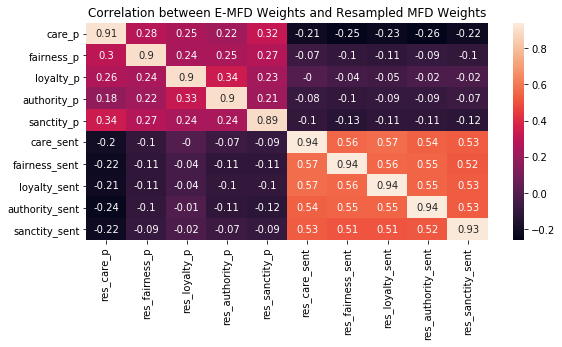

In [74]:
fig, ax = plt.subplots(figsize=(9,4))
sns.heatmap(joined.corr()[[c for c in joined.columns if c.startswith('res')]].loc[probabilities+sent_cols].round(2), annot=True)
plt.title('Correlation between E-MFD Weights and Resampled MFD Weights')